# Cluster points and explore boundary *blurriness* with A-DBSCAN 

In [63]:
%matplotlib inline

import pandas
import geopandas
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib.cg.alpha_shapes import alpha_shape_auto

import sys
sys.path.append("../")
from esda.adbscan import ADBSCAN

## Data

In [9]:
tab = pandas.read_csv("data/berlin-listings.csv")
tab.head(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,10.0,f,NaN,NaN,t,flexible,f,f,3,2.00
1,1,17227881,https://www.airbnb.com/rooms/17227881,20170507222235,2017-05-08,Modernes Zimmer in Berlin Pankow,Es ist ein schönes gepflegtes und modernes Zim...,Das Haus befindet sich direkt vor eine Tram Ha...,Es ist ein schönes gepflegtes und modernes Zim...,none,...,10.0,f,NaN,NaN,t,flexible,f,f,1,1.29


Convert into a `GeoDataFrame`:

In [14]:
db_ll = geopandas.GeoDataFrame(tab,
                               geometry=geopandas.points_from_xy(tab.longitude, tab.latitude),
                               crs={'init': 'epsg:4326'}
                              )

Project it:

In [15]:
db = db_ll.to_crs(epsg=5243)

Voila!

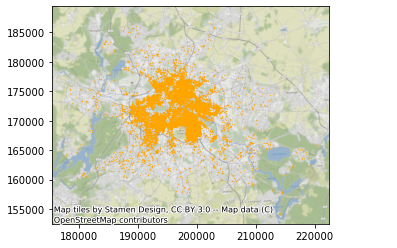

In [18]:
ax = db.plot(markersize=0.1, color='orange')
cx.add_basemap(ax, crs=db.crs);

Add XY coords back to table:

In [22]:
db["X"] = db.geometry.x
db["Y"] = db.geometry.y

## Identify clusters of AirBnb

In [21]:
db.shape[0] * 0.01

200.53

In [23]:
%%time
# Get clusters
adbs = ADBSCAN(500, 200, n_jobs=-1)
adbs.fit(db)

../esda/adbscan.py:186: UserWarning: Multi-core implementation only works on relabelling solutions. Execution of draws is still sequential.
  warnings.warn(warn_msg)


CPU times: user 1min 36s, sys: 1.98 s, total: 1min 38s
Wall time: 1min 48s


In [26]:
adbs.votes.head()

,lbls,pct
0,-1,1.0
1,-1,1.0
2,-1,1.0
3,-1,1.0
4,-1,1.0


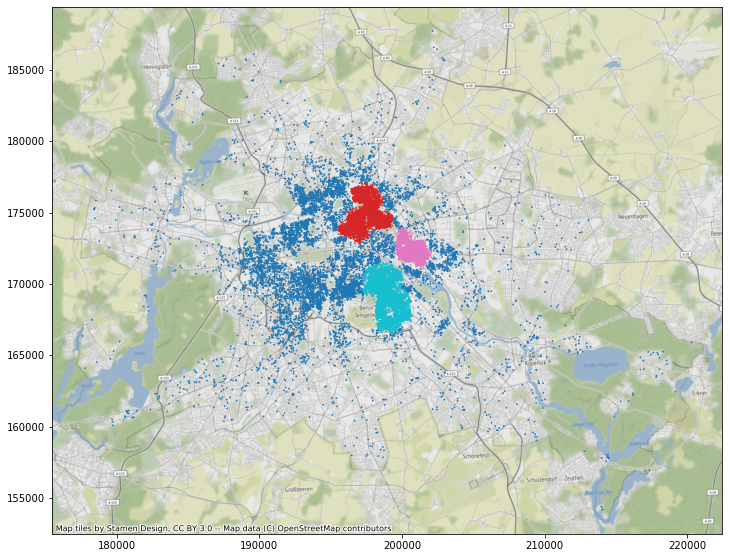

In [31]:
ax = db.assign(lbls=adbs.votes["lbls"])\
       .plot(column="lbls", 
             categorical=True,
             markersize=0.5,
             figsize=(12, 12)
            )
cx.add_basemap(ax, crs=db.crs);

Draw boundary with $\alpha$-shapes:

In [50]:
%%time
in_cluster_ids = adbs.votes.query("lbls != '-1'")
def get_boundary(db):
    xys = np.array([db.geometry.x,
                    db.geometry.y
                   ]
                  ).T
    return alpha_shape_auto(xys)
polys = db.reindex(in_cluster_ids.index)\
          .groupby(in_cluster_ids["lbls"])\
          .apply(get_boundary)
polys = geopandas.GeoSeries(polys, crs=db.crs)

CPU times: user 8.03 s, sys: 110 ms, total: 8.14 s
Wall time: 8.11 s


In [52]:
polys

lbls
0    POLYGON ((197373.0253587792 173124.685930629, ...
1    POLYGON ((201668.981316727 172673.5503698761, ...
2    POLYGON ((199418.5597126883 171102.5094935126,...
dtype: object

In [99]:
cx.providers.CartoDB.keys()

dict_keys(['Positron', 'PositronNoLabels', 'PositronOnlyLabels', 'DarkMatter', 'DarkMatterNoLabels', 'DarkMatterOnlyLabels', 'Voyager', 'VoyagerNoLabels', 'VoyagerOnlyLabels', 'VoyagerLabelsUnder'])

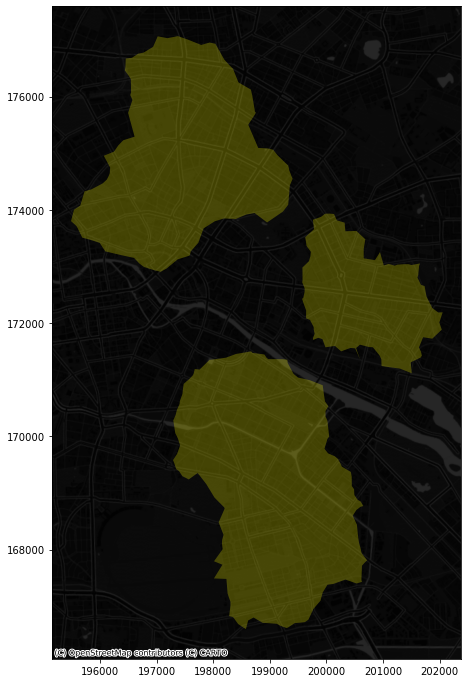

In [105]:
ax = polys.plot(alpha=0.25,
                color='yellow',
                figsize=(12, 12)
               )
cx.add_basemap(ax, 
               crs=polys.crs,
               url=cx.providers.CartoDB.DarkMatterNoLabels
              );

And a more zoomed-in view, dimming out areas outside each cluster:

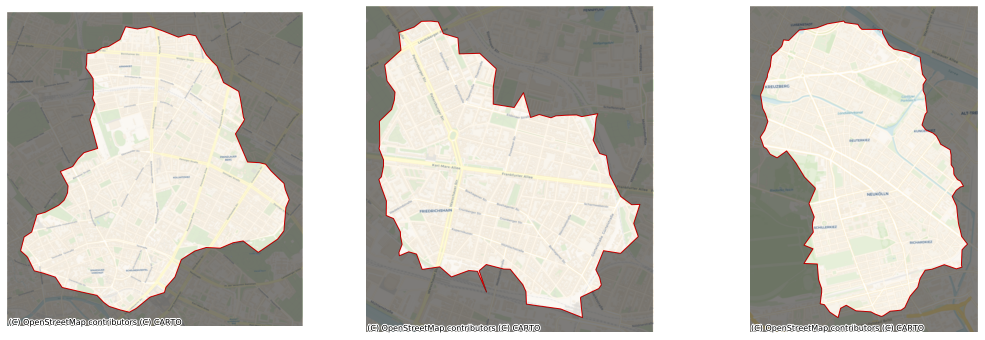

In [69]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    # Plot the boundary of the cluster found
    ax = polys[[i]].plot(ax=ax, 
                         edgecolor="red",
                         facecolor="none"
                        )
    # Add basemap
    cx.add_basemap(ax, 
                   crs=polys.crs, 
                   url=cx.providers.CartoDB.Voyager
                  )
    # Extra to dim non-cluster areas
    (minX, maxX), (minY, maxY) = ax.get_xlim(), ax.get_ylim()
    bb = Polygon([(minX, minY),
                  (maxX, minY),
                  (maxX, maxY),
                  (minX, maxY),
                  (minX, minY)
                 ])
    geopandas.GeoSeries([bb.difference(polys[i])],
                        crs=polys.crs
                       ).plot(ax=ax, 
                              color='k', 
                              alpha=0.5
                             )
    ax.set_axis_off()
plt.show()

In [68]:
cx.providers.CartoDB.keys()

dict_keys(['Positron', 'PositronNoLabels', 'PositronOnlyLabels', 'DarkMatter', 'DarkMatterNoLabels', 'DarkMatterOnlyLabels', 'Voyager', 'VoyagerNoLabels', 'VoyagerOnlyLabels', 'VoyagerLabelsUnder'])

## Explore blundary *blurriness*